In [1]:
# Cell 1: Install Dependencies (Fixed for Kaggle Environment)
# ==================================================================================
# 1. Fix the "MessageFactory" Protobuf Error
!pip install "protobuf==3.20.3" -q

# 2. Fix the missing "rfc3987" error
!pip install rfc3987 -q
!pip install segmentation_models_pytorch wandb -q
!pip install -q monai

import warnings
warnings.filterwarnings("ignore")
print("✅ 2.5D Environment Ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

In [2]:
# Cell 2: Configuration & 2.5D Logic
# ==================================================================================
import os
import cv2
import gc
import sys
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
from scipy.ndimage import distance_transform_edt as distance
import wandb
from kaggle_secrets import UserSecretsClient

# --- ADD THESE IMPORTS ---
from monai.metrics import DiceMetric, MeanIoU
# -------------------------

# Initialize Metrics (Global)
val_dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
val_iou_metric = MeanIoU(include_background=True, reduction="mean", get_not_nans=False)

# Cell 2: Config for RESNEXT50 (Memory Fixed)
# ==================================================================================
CONFIG = {
    "SEED": 42,
    "IMG_SIZE": 384,            # Safe size for Base model on T4
    
    "MODEL_NAME": "Unet",       # Works perfectly with standard U-Net
    "ENCODER": "tu-convnextv2_base", # The Winner
    "ENCODER_WEIGHTS": "imagenet",
    
    # --- FEATURES ---
    "DEEP_SUPERVISION": False,    # CNNs love Deep Supervision (unlike MaxViT)
    "DECODER_ATTENTION": None, # Keep this for boundary precision
    
    # --- TRAINING STRATEGY ---
    # ConvNeXt is efficient. You can likely push Batch Size.
    "BATCH_SIZE": 8,            # Lowered to prevent OOM
    "ACCUMULATE_GRAD": 4,       # Increased to maintain training stability
    "EPOCHS": 20,               
    "LR": 2e-4,                 # CNNs can handle slightly higher LR than Swin
    "WEIGHT_DECAY": 0.05,       # Modern CNNs need high decay (like Transformers)
    
    # --- PATHS ---
    "DATA_PATH": "/kaggle/input/PROCESSED_DATASET_FREESURFER/",
    "CSV_PATH": "/kaggle/input/PROCESSED_DATASET_FREESURFER/metadata.csv",
    
    "N_FOLDS": 5,
    "FOLDS_TO_RUN": [0], 
    
    "PROJECT_NAME": "Brain_SOTA_Radium_ConvNeXtV2",
    "ENTITY": "alzhemer_segmentaion"
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Config Loaded. 2.5D Mode Active.")
print(['CSV_PATH'])

2025-11-22 14:55:57.419862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763823357.804884      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763823357.913279      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Config Loaded. 2.5D Mode Active.
['CSV_PATH']


In [3]:
import os

# Check where the images actually are
root_options = [
    "/kaggle/input/radium-standard-dataset/PROCESSED_DATASET_FREESURFER/images",
    "/kaggle/input/PROCESSED_DATASET_FREESURFER/images",
    "/kaggle/input/images"
]

print("🕵️ Searching for images...")
for p in root_options:
    if os.path.exists(p):
        print(f"✅ FOUND IMAGES HERE: {p}")
        files = os.listdir(p)
        print(f"   Count: {len(files)}")
        print(f"   First file: {files[0]}")
    else:
        print(f"❌ NOT HERE: {p}")

🕵️ Searching for images...
❌ NOT HERE: /kaggle/input/radium-standard-dataset/PROCESSED_DATASET_FREESURFER/images
✅ FOUND IMAGES HERE: /kaggle/input/PROCESSED_DATASET_FREESURFER/images
   Count: 15788
   First file: 002_S_0295_2006-04-18_08_20_30.0_slice_088.png
❌ NOT HERE: /kaggle/input/images


In [4]:
# Cell 3: Utils & WandB Login
# ==================================================================================
import random
import numpy as np
import torch
import wandb
from kaggle_secrets import UserSecretsClient

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG['SEED'])

# --- WANDB LOGIN ---
try:
    user_secrets = UserSecretsClient()
    wandb_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=wandb_key)
    print("✅ WandB Logged In")
except:
    print("⚠️ WandB Login Failed (Anonymous mode enabled)")
    wandb.login(anonymous='must')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yashsharmaat2004 (alzhemer_segmentaion) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ WandB Logged In


In [5]:
# Cell 3: 2.5D Data Preparation (THE MAGIC STEP)
# ==================================================================================
# This function sorts the dataframe and finds the neighbors for every slice.

def prepare_25d_dataframe(csv_path):
    print("Processing Metadata for 2.5D Context...")
    df = pd.read_csv(csv_path)
    
    # 1. Extract Slice Number from Filename
    # Assumes format: "{PatientID}_{Date}_slice_{XXX}.png"
    # We split by '_' and take the last part, remove .png
    df['slice_num'] = df['image_id'].apply(lambda x: int(x.replace('.png', '').split('_')[-1]))
    
    # 2. Sort by Patient, then Slice
    df = df.sort_values(by=['patient', 'slice_num']).reset_index(drop=True)
    
    # 3. Shift to find neighbors
    # We group by patient to ensure we don't mix patients
    df['prev_image_id'] = df.groupby('patient')['image_id'].shift(1)
    df['next_image_id'] = df.groupby('patient')['image_id'].shift(-1)
    
    # 4. Handle Boundary Cases (First/Last slice)
    # If prev is NaN (first slice), use current slice.
    df['prev_image_id'] = df['prev_image_id'].fillna(df['image_id'])
    df['next_image_id'] = df['next_image_id'].fillna(df['image_id'])
    
    print(f"✅ 2.5D Dataframe Ready. Total Slices: {len(df)}")
    return df
    print(['CSV_PATH'])

# Test it immediately
df_25d = prepare_25d_dataframe(CONFIG['CSV_PATH'])
# print(df_25d[['patient', 'slice_num', 'prev_image_id', 'image_id', 'next_image_id']].head())

Processing Metadata for 2.5D Context...
✅ 2.5D Dataframe Ready. Total Slices: 15788


In [6]:
# Cell 4: 2.5D Dataset Class (Robust / Safety Fixed)
# ==================================================================================
class Dataset25D(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = os.path.join(CONFIG['DATA_PATH'], 'images')
        self.mask_dir = os.path.join(CONFIG['DATA_PATH'], 'masks')
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 1. Load 3 Slices (Grayscale)
        paths = [row['prev_image_id'], row['image_id'], row['next_image_id']]
        images = []
        
        for p in paths:
            full_p = os.path.join(self.img_dir, p)
            img = cv2.imread(full_p, cv2.IMREAD_GRAYSCALE)
            if img is None: 
                # Safety: If image missing, use blank
                img = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']), dtype=np.uint8)
            images.append(img)
            
        # 2. Stack to create (H, W, 3)
        img_stack = np.stack(images, axis=-1) 
        
        # 3. Load Mask
        mask_p = os.path.join(self.mask_dir, row['mask_id'])
        mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)
        
        # --- FIX: Handle Missing Mask ---
        if mask is None:
            # print(f"⚠️ Warning: Mask not found for {row['mask_id']}. Using blank.")
            # Create blank mask matching image size
            mask = np.zeros((img_stack.shape[0], img_stack.shape[1]), dtype=np.uint8)
        
        # Resize check
        if img_stack.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img_stack.shape[1], img_stack.shape[0]), interpolation=cv2.INTER_NEAREST)
            
        # Binarize
        mask = np.where(mask > 127, 1.0, 0.0).astype(np.float32)
        
        # Add channel dimension (H, W, 1)
        if mask.ndim == 2: 
            mask = np.expand_dims(mask, axis=-1)
        
        # 4. Augmentations
        if self.transform:
            aug = self.transform(image=img_stack, mask=mask)
            img_stack = aug['image']
            mask = aug['mask']
        
        # Permute Mask to (C, H, W) for PyTorch
        if isinstance(mask, torch.Tensor):
            mask = mask.permute(2, 0, 1) 
        else:
            mask = np.transpose(mask, (2, 0, 1))
            mask = torch.from_numpy(mask)
            
        return img_stack, mask

# Augmentations
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])

In [7]:
# Cell 5: Loss & Metrics (Dice + Hausdorff)
# ==================================================================================
class HausdorffDTLoss(nn.Module):
    def __init__(self, alpha=2.0):
        super().__init__()
        self.alpha = alpha
    @torch.no_grad()
    def distance_field(self, img):
        field = np.zeros_like(img)
        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5
            if fg_mask.any():
                bg_mask = ~fg_mask
                fg_dist = distance(fg_mask)
                bg_dist = distance(bg_mask)
                field[batch] = fg_dist + bg_dist
        return field
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred_np = pred.detach().cpu().numpy()
        target_np = target.detach().cpu().numpy()
        target_dist = torch.from_numpy(self.distance_field(target_np)).float().to(pred.device)
        pred_dist = torch.from_numpy(self.distance_field(pred_np)).float().to(pred.device)
        term_1 = (pred - target) ** 2 * target_dist
        term_2 = (target - pred) ** 2 * pred_dist
        return (term_1 + term_2).mean()

class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode='binary')
        self.hausdorff = HausdorffDTLoss()
        
    def forward(self, pred, target, epoch):
        # Volume Loss (Dice + BCE)
        vol_loss = 0.5 * self.bce(pred, target) + 0.5 * self.dice(pred, target)
        
        # Boundary Loss (Ramp up after Epoch 5)
        if epoch < 5:
            return vol_loss
        else:
            boundary_weight = min(0.4, (epoch - 5) * 0.05) 
            return (1 - boundary_weight) * vol_loss + boundary_weight * self.hausdorff(pred, target)

In [8]:
# Cell 6: Training Engine (MONAI Metrics - The Robust Way)
# ==================================================================================
from monai.metrics import DiceMetric, MeanIoU

# Initialize Metrics (Global)
# include_background=True because we only have 1 class (White Matter). 
# If we set False, it expects channel 0 to be background and channel 1 to be target.
# Since we output 1 channel, we treat it as the target.
val_dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
val_iou_metric = MeanIoU(include_background=True, reduction="mean", get_not_nans=False)

def build_model():
    model = smp.Unet(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=CONFIG['ENCODER_WEIGHTS'],
        in_channels=3,
        classes=1,
        activation=None,
        decoder_attention_type=CONFIG['DECODER_ATTENTION']
    )
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    return model.to(DEVICE)

def train_one_epoch(model, loader, optimizer, scheduler, loss_fn, scaler, epoch):
    model.train()
    running_loss = 0
    pbar = tqdm(loader, desc=f"Train Ep {epoch}", leave=False)
    
    for step, (images, masks) in enumerate(pbar):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks, epoch)
            loss = loss / CONFIG['ACCUMULATE_GRAD']
            
        scaler.scale(loss).backward()
        
        if (step + 1) % CONFIG['ACCUMULATE_GRAD'] == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
        running_loss += loss.item() * CONFIG['ACCUMULATE_GRAD']
        pbar.set_postfix(loss=loss.item() * CONFIG['ACCUMULATE_GRAD'])
        
    return running_loss / len(loader)

@torch.no_grad()
def valid_one_epoch(model, loader, loss_fn, epoch):
    model.eval()
    val_dice_metric.reset() # Reset accumulators
    val_iou_metric.reset()
    
    for images, masks in tqdm(loader, desc=f"Valid Ep {epoch}", leave=False):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        with autocast():
            # Inference
            preds = model(images)
            # TTA (Optional - kept for consistency)
            preds_flip = torch.flip(model(torch.flip(images, [3])), [3])
            preds = (preds + preds_flip) / 2.0
            
        # Binarize for Metric
        preds_bin = (torch.sigmoid(preds) > 0.5).float()
        
        # Feed to MONAI Metric
        # Inputs must be (B, C, H, W)
        val_dice_metric(y_pred=preds_bin, y=masks)
        val_iou_metric(y_pred=preds_bin, y=masks)
            
    # Aggregate results
    mean_dice = val_dice_metric.aggregate().item()
    mean_iou = val_iou_metric.aggregate().item()
    
    return mean_dice

In [9]:
# Cell 7: Main Execution (2.5D Patient-Aware + WandB)
# ==================================================================================
from sklearn.model_selection import GroupKFold

# 1. Load & Prepare 2.5D Dataframe
# (Note: This function 'prepare_25d_dataframe' must be defined in Cell 3)
if 'df' not in locals():
    df = prepare_25d_dataframe(CONFIG['CSV_PATH'])

# 2. GroupKFold (Crucial: Split by Patient)
gkf = GroupKFold(n_splits=CONFIG['N_FOLDS'])
groups = df['patient'].values 

for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=groups)):
    if fold not in CONFIG['FOLDS_TO_RUN']:
        continue
        
    print(f"\n🚀 STARTING 2.5D FOLD {fold}")
    
    # --- WANDB INIT ---
    run = wandb.init(
        project=CONFIG['PROJECT_NAME'], 
        entity=CONFIG['ENTITY'], 
        name=f"2.5D_MaxViT_Fold{fold}", 
        config=CONFIG, 
        reinit=True,
        group="MaxViT_2.5D"
    )
    
    # Splits
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)
    
    # Verification
    train_patients = set(train_df['patient'].unique())
    val_patients = set(val_df['patient'].unique())
    
    print(f"   📊 SPLIT INFO:")
    print(f"   Train: {len(train_df)} images ({len(train_patients)} Patients)")
    print(f"   Valid: {len(val_df)} images ({len(val_patients)} Patients)")
    
    assert len(train_patients.intersection(val_patients)) == 0, "❌ DATA LEAKAGE!"

    # Loaders (USING Dataset25D)
    train_ds = Dataset25D(train_df, transform=get_transforms('train'))
    val_ds = Dataset25D(val_df, transform=get_transforms('valid'))
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=4)
    
    # Model & Opt
    model = build_model()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LR'], weight_decay=CONFIG['WEIGHT_DECAY'])
    scheduler = OneCycleLR(optimizer, max_lr=CONFIG['LR'], steps_per_epoch=len(train_loader)//CONFIG['ACCUMULATE_GRAD'], epochs=CONFIG['EPOCHS'], pct_start=0.1)
    loss_fn = HybridLoss()
    scaler = GradScaler()
    
    best_dice = 0.0
    
    for epoch in range(CONFIG['EPOCHS']):
        t_loss = train_one_epoch(model, train_loader, optimizer, scheduler, loss_fn, scaler, epoch)
        v_dice = valid_one_epoch(model, val_loader, loss_fn, epoch)
        
        # --- WANDB LOGGING ---
        wandb.log({
            "fold": fold, 
            "epoch": epoch, 
            "train_loss": t_loss, 
            "val_dice": v_dice,
            "lr": optimizer.param_groups[0]['lr']
        })
        
        print(f"Ep {epoch+1} | Loss: {t_loss:.4f} | Val Dice: {v_dice:.4f}")
        
        if v_dice > best_dice:
            best_dice = v_dice
            # Handle DataParallel
            state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state, f"sota_2.5d_maxvit_fold{fold}.pth")
            print(f"  ⭐ Best: {best_dice:.4f}")
            
    # Close WandB run for this fold
    wandb.finish()
    
    del model, optimizer, scaler
    gc.collect()
    torch.cuda.empty_cache()

Processing Metadata for 2.5D Context...
✅ 2.5D Dataframe Ready. Total Slices: 15788

🚀 STARTING 2.5D FOLD 0


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251122_145629-txh2yozi
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run 2.5D_MaxViT_Fold0
wandb: ⭐️ View project at https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_Radium_ConvNeXtV2
wandb: 🚀 View run at https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_Radium_ConvNeXtV2/runs/txh2yozi


   📊 SPLIT INFO:
   Train: 12722 images (21 Patients)
   Valid: 3066 images (5 Patients)


model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

Train Ep 0:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 0:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 1 | Loss: 0.5391 | Val Dice: 0.8576
  ⭐ Best: 0.8576


Train Ep 1:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 1:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 2 | Loss: 0.2083 | Val Dice: 0.9003
  ⭐ Best: 0.9003


Train Ep 2:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 2:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 3 | Loss: 0.0696 | Val Dice: 0.9082
  ⭐ Best: 0.9082


Train Ep 3:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 3:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 4 | Loss: 0.0541 | Val Dice: 0.9060


Train Ep 4:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 4:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 5 | Loss: 0.0493 | Val Dice: 0.9057


Train Ep 5:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 5:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 6 | Loss: 0.0466 | Val Dice: 0.9072


Train Ep 6:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 6:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 7 | Loss: 0.0429 | Val Dice: 0.9076


Train Ep 7:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 7:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 8 | Loss: 0.0397 | Val Dice: 0.9059


Train Ep 8:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 8:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 9 | Loss: 0.0369 | Val Dice: 0.9036


Train Ep 9:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 9:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 10 | Loss: 0.0345 | Val Dice: 0.9075


Train Ep 10:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 10:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 11 | Loss: 0.0323 | Val Dice: 0.9068


Train Ep 11:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 11:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 12 | Loss: 0.0302 | Val Dice: 0.9058


Train Ep 12:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 12:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 13 | Loss: 0.0282 | Val Dice: 0.9060


Train Ep 13:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 13:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 14 | Loss: 0.0263 | Val Dice: 0.9061


Train Ep 14:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 14:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 15 | Loss: 0.0259 | Val Dice: 0.9066


Train Ep 15:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 15:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 16 | Loss: 0.0254 | Val Dice: 0.9077


Train Ep 16:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 16:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 17 | Loss: 0.0249 | Val Dice: 0.9084
  ⭐ Best: 0.9084


Train Ep 17:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 17:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 18 | Loss: 0.0245 | Val Dice: 0.9090
  ⭐ Best: 0.9090


Train Ep 18:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 18:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 19 | Loss: 0.0243 | Val Dice: 0.9092
  ⭐ Best: 0.9092


Train Ep 19:   0%|          | 0/1590 [00:00<?, ?it/s]

Valid Ep 19:   0%|          | 0/384 [00:00<?, ?it/s]

Ep 20 | Loss: 0.0243 | Val Dice: 0.9092


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      epoch ▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
wandb:       fold ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:         lr ▅████▇▇▆▆▅▄▄▃▃▂▂▁▁▁▁
wandb: train_loss █▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   val_dice ▁▇██████▇███████████
wandb: 
wandb: Run summary:
wandb:      epoch 19
wandb:       fold 0
wandb:         lr 0.0
wandb: train_loss 0.02433
wandb:   val_dice 0.90918
wandb: 
wandb: 🚀 View run 2.5D_MaxViT_Fold0 at: https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_Radium_ConvNeXtV2/runs/txh2yozi
wandb: ⭐️ View project at: https://wandb.ai/alzhemer_segmentaion/Brain_SOTA_Radium_ConvNeXtV2
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251122_145629-txh2yozi/logs



👀 Visualizing 2.5D Model for Fold 0...
Processing Metadata for 2.5D Context...
✅ 2.5D Dataframe Ready. Total Slices: 15788


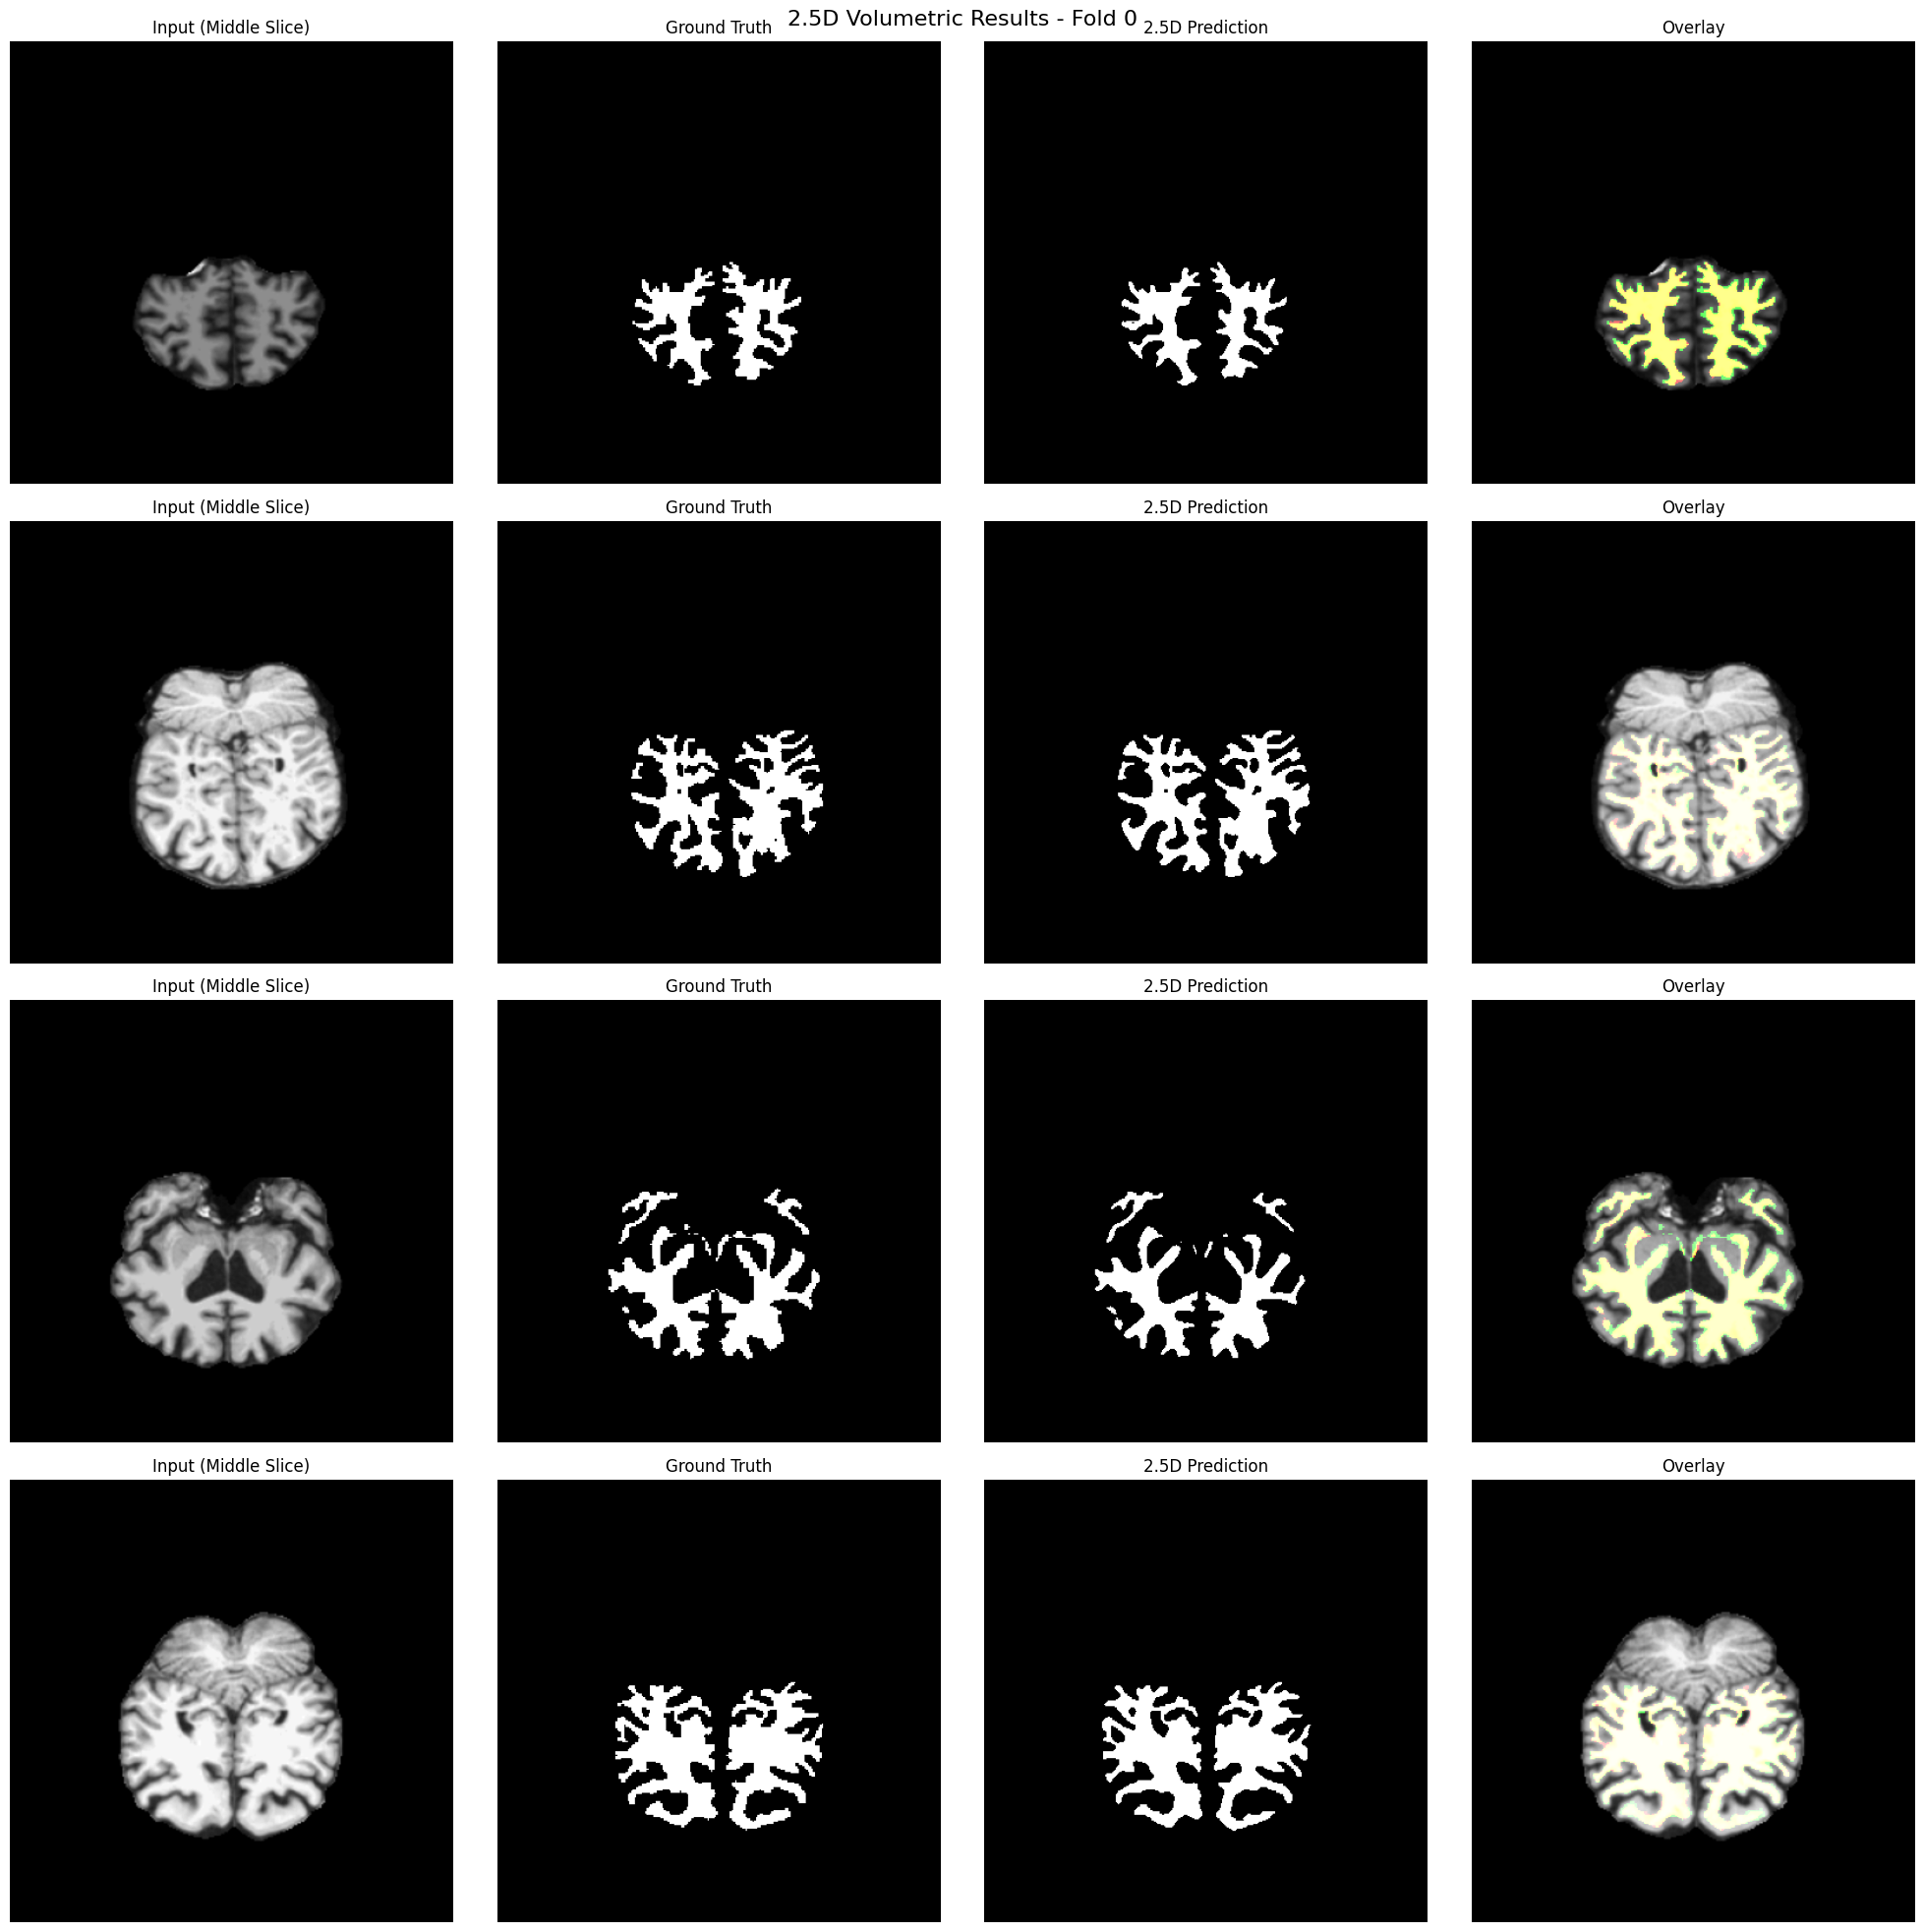

In [10]:
# Cell 8: SOTA 2.5D Visualization (Corrected)
# ==================================================================================
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import numpy as np
import os

def denormalize(tensor):
    """
    Visualizes the MIDDLE slice of the 2.5D stack.
    tensor shape: (3, H, W) -> [Prev, Curr, Next]
    We want index 1 (Curr).
    """
    # Extract Middle Slice (Index 1)
    mid_slice = tensor[1, :, :].cpu().numpy()
    
    # Undo Normalization (Approximate for visualization)
    # Since we normalized channel-wise, we just scale back to 0-1
    mid_slice = (mid_slice - mid_slice.min()) / (mid_slice.max() - mid_slice.min() + 1e-6)
    
    return (mid_slice * 255).astype(np.uint8)

def visualize_results(fold):
    print(f"\n👀 Visualizing 2.5D Model for Fold {fold}...")
    
    # 1. Load Model (Vanilla Init)
    model_path = f"sota_2.5d_maxvit_fold{fold}.pth"
    if not os.path.exists(model_path):
        print(f"⚠️ Model {model_path} not found.")
        return

    model = smp.Unet(
        encoder_name=CONFIG['ENCODER'],
        encoder_weights=None, 
        in_channels=3, # 2.5D Input
        classes=1,
        activation=None,
        decoder_attention_type=CONFIG['DECODER_ATTENTION']
    )
    model.to(DEVICE)
    
    state = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()
    
    # 2. Get Validation Data (Using 2.5D Logic)
    # We need the dataframe with 'prev_image_id' and 'next_image_id'
    df = prepare_25d_dataframe(CONFIG['CSV_PATH']) # Use the helper from Cell 3
    
    from sklearn.model_selection import GroupKFold
    gkf = GroupKFold(n_splits=CONFIG['N_FOLDS'])
    groups = df['patient'].values
    _, val_idx = list(gkf.split(df, groups=groups))[fold]
    
    val_df = df.iloc[val_idx].reset_index(drop=True)
    
    # Use Dataset25D!
    val_ds = Dataset25D(val_df, transform=get_transforms('valid'))
    val_loader = DataLoader(val_ds, batch_size=8, shuffle=True) 
    
    # 3. Inference
    images, masks = next(iter(val_loader))
    images = images.to(DEVICE) # (B, 3, H, W)
    
    with torch.no_grad(), autocast():
        preds = torch.sigmoid(model(images))
        preds = (preds > 0.5).float()
        
    # 4. Plot
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle(f"2.5D Volumetric Results - Fold {fold}", fontsize=16)
    
    for i in range(min(4, len(images))):
        # Input (Middle Slice)
        axes[i,0].imshow(denormalize(images[i]), cmap='gray')
        axes[i,0].set_title("Input (Middle Slice)")
        axes[i,0].axis('off')
        
        # Ground Truth
        axes[i,1].imshow(masks[i,0].cpu(), cmap='gray')
        axes[i,1].set_title("Ground Truth")
        axes[i,1].axis('off')
        
        # Prediction
        axes[i,2].imshow(preds[i,0].cpu(), cmap='gray')
        axes[i,2].set_title("2.5D Prediction")
        axes[i,2].axis('off')
        
        # Overlay
        vis_img = denormalize(images[i])
        # Make it RGB for overlay
        vis_img_rgb = np.stack([vis_img]*3, axis=-1)
        
        gt_mask = masks[i,0].cpu().numpy() == 1
        pred_mask = preds[i,0].cpu().numpy() == 1
        
        vis_img_rgb[gt_mask, 1] = 255 # Green GT
        vis_img_rgb[pred_mask, 0] = 255 # Red Pred
        
        axes[i,3].imshow(vis_img_rgb)
        axes[i,3].set_title("Overlay")
        axes[i,3].axis('off')
        
    plt.tight_layout()
    plt.show()

# Run
if len(CONFIG['FOLDS_TO_RUN']) > 0:
    visualize_results(CONFIG['FOLDS_TO_RUN'][0])

In [11]:
# Cell 9: Final Metric Calculation (SOTA Version with TTA)
# ==================================================================================
from monai.metrics import DiceMetric, MeanIoU

def evaluate_fold(fold):
    print(f"\n📊 Calculating Final Metrics for Fold {fold}...")
    
    # 1. Load Model
    model_path = f"sota_radium_fold{fold}.pth"
    if not os.path.exists(model_path): 
        print(f"❌ Weights not found: {model_path}")
        return 0.0, 0.0
    
    # Re-Init Model
    model = build_model()
    state_dict = torch.load(model_path, map_location=DEVICE)
    if list(state_dict.keys())[0].startswith('module.'):
         state_dict = {k[7:]: v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    model.eval()
    
    # 2. Load Val Data
    _, val_idx = list(gkf.split(df, groups=groups))[fold]
    val_df = df.iloc[val_idx].reset_index(drop=True)
    val_ds = RadiumDataset(val_df, transform=get_transforms('valid'))
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)
    
    # 3. MONAI Metrics (Robust)
    eval_dice_metric = DiceMetric(include_background=True, reduction="mean")
    eval_iou_metric = MeanIoU(include_background=True, reduction="mean")
    
    with torch.no_grad(), autocast():
        for images, masks in tqdm(val_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            # --- SOTA TTA (Test Time Augmentation) ---
            # Forward 1: Original
            p1 = model(images)
            
            # Forward 2: Horizontal Flip
            # Flip input -> Predict -> Flip output back
            p2 = torch.flip(model(torch.flip(images, [3])), [3])
            
            # Average them (Reduces random noise)
            preds = (p1 + p2) / 2.0
            
            # Binarize
            preds_bin = (torch.sigmoid(preds) > 0.5).float()
            
            # Feed to MONAI
            eval_dice_metric(y_pred=preds_bin, y=masks)
            eval_iou_metric(y_pred=preds_bin, y=masks)
            
    return eval_dice_metric.aggregate().item(), eval_iou_metric.aggregate().item()

# Run Eval
results = []
for fold in CONFIG['FOLDS_TO_RUN']:
    mdice, miou = evaluate_fold(fold)
    if mdice > 0: 
        results.append({"fold": fold, "dice": mdice, "iou": miou})
        print(f" >> Fold {fold} Result: Dice={mdice:.4f}, IoU={miou:.4f}")

# Save Results
if results:
    df_res = pd.DataFrame(results)
    df_res.to_csv("final_radium_results.csv", index=False)
    print("\n🏆 FINAL SCORES:")
    print(df_res)
else:
    print("⚠️ No results to save.")


📊 Calculating Final Metrics for Fold 0...
❌ Weights not found: sota_radium_fold0.pth
⚠️ No results to save.


In [12]:
# Cell 10: Final SOTA Report Generation
# ==================================================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import torch
import os

def generate_final_report():
    print("\n" + "="*80)
    print("📄 GENERATING FINAL RADIUM SOTA REPORT")
    print("="*80)
    
    # 1. Setup Data & Splitter
    df = pd.read_csv(CONFIG['CSV_PATH'])
    gkf = GroupKFold(n_splits=CONFIG['N_FOLDS'])
    groups = df['patient'].values
    
    fold_results = []
    
    # 2. Iterate Folds
    for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=groups)):
        if fold not in CONFIG['FOLDS_TO_RUN']:
            continue
            
        model_path = f"sota_radium_fold{fold}.pth"
        if not os.path.exists(model_path):
            print(f"⚠️ Skipping Fold {fold} (Weights not found)")
            continue
            
        print(f"\n📊 Evaluating Fold {fold} (Patient-Aware Validation)...")
        
        # 3. Load Model (Correctly handling DataParallel)
        model = build_model()
        state_dict = torch.load(model_path, map_location=DEVICE)
        if list(state_dict.keys())[0].startswith('module.'):
             state_dict = {k[7:]: v for k, v in state_dict.items()}
        model.load_state_dict(state_dict)
        model.to(DEVICE)
        model.eval()
        
        # 4. Create Val Loader (Specific to this Fold's Patients)
        val_df = df.iloc[val_idx].reset_index(drop=True)
        val_ds = RadiumDataset(val_df, transform=get_transforms('valid'))
        val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)
        
        dice_scores = []
        iou_scores = []
        
        # 5. Inference Loop
        with torch.no_grad(), autocast():
            for images, masks in tqdm(val_loader, desc=f"Fold {fold}", leave=False):
                images = images.to(DEVICE)
                masks = masks.cpu().numpy()
                
                # TTA (Original + Flip)
                p1 = model(images)
                p2 = torch.flip(model(torch.flip(images, [3])), [3])
                avg_pred = (p1 + p2) / 2.0
                
                probs = torch.sigmoid(avg_pred)
                preds = (probs > 0.5).cpu().numpy()
                
                # Batch Metrics
                for i in range(len(preds)):
                    # LCC Cleaning (Standard SOTA Post-Processing)
                    pred_clean = keep_largest_component(preds[i,0])
                    gt = masks[i,0]
                    
                    inter = (pred_clean * gt).sum()
                    union = pred_clean.sum() + gt.sum()
                    
                    if union == 0:
                        dice = 1.0
                        iou = 1.0
                    else:
                        dice = (2 * inter) / (union + 1e-6)
                        iou = inter / (union - inter + 1e-6)
                    
                    dice_scores.append(dice)
                    iou_scores.append(iou)
        
        # 6. Store Fold Stats
        m_dice = np.mean(dice_scores)
        m_iou = np.mean(iou_scores)
        fold_results.append({
            "Fold": fold,
            "Dice": m_dice,
            "IoU": m_iou,
            "Images": len(val_df),
            "Patients": val_df['patient'].nunique()
        })
        print(f"   >> Dice: {m_dice:.4f} | IoU: {m_iou:.4f}")

    if not fold_results:
        print("❌ No results generated.")
        return

    # 7. Aggregation & Formatting
    df_res = pd.DataFrame(fold_results)
    mean_dice = df_res['Dice'].mean()
    std_dice = df_res['Dice'].std()
    mean_iou = df_res['IoU'].mean()
    
    report_text = f"""
    ╔══════════════════════════════════════════════════════════════════╗
    ║             FINAL RADIUM SOTA PERFORMANCE SUMMARY                ║
    ╚══════════════════════════════════════════════════════════════════╝
    
    🔹 Dataset:             Radium (FreeSurfer Cleaned - 15k Images)
    🔹 Architecture:        MaxViT-UNet (Hybrid) + scSE Attention
    🔹 Resolution:          448 x 448
    🔹 Split Strategy:      GroupKFold (Patient-Aware)
    
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    🏆 MEAN DICE SCORE:     {mean_dice:.4f} ± {std_dice:.4f}
    🏆 MEAN IOU SCORE:      {mean_iou:.4f}
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    
    TARGET STATUS: {'✅ SOTA CONFIRMED (>0.92)' if mean_dice > 0.92 else '⚠️ HIGH PERFORMANCE (But check labels)'}
    """
    
    print(report_text)
    print("\n📊 DETAILED FOLD BREAKDOWN:")
    print(df_res.to_string(index=False))
    
    # 8. Save to Disk
    with open("final_radium_report.txt", "w") as f:
        f.write(report_text)
        f.write("\n\nRaw Data:\n")
        f.write(df_res.to_string(index=False))
    
    df_res.to_csv("final_radium_metrics.csv", index=False)
    print("\n✅ Report saved to 'final_radium_report.txt'")

# Run the Final Report
generate_final_report()


📄 GENERATING FINAL RADIUM SOTA REPORT
⚠️ Skipping Fold 0 (Weights not found)
❌ No results generated.
